In [117]:
!pip install numpy pillow matplotlib

# **Algoritmo Theta***

In [118]:
import math
import heapq
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


# ======================================
# 2) Utilidades: vecinos + line of sight
# ======================================
def in_bounds(grid: np.ndarray, x: int, y: int) -> bool:
    h, w = grid.shape
    return 0 <= x < w and 0 <= y < h

def is_free(grid: np.ndarray, x: int, y: int) -> bool:
    return in_bounds(grid, x, y) and grid[y, x] == 0

def neighbors8(grid: np.ndarray, x: int, y: int):
    # (dx, dy, cost)
    moves = [
        (-1,  0, 1.0), (1,  0, 1.0), (0, -1, 1.0), (0,  1, 1.0),
        (-1, -1, math.sqrt(2)), (1, -1, math.sqrt(2)),
        (-1,  1, math.sqrt(2)), (1,  1, math.sqrt(2)),
    ]
    for dx, dy, c in moves:
        nx, ny = x + dx, y + dy
        if is_free(grid, nx, ny):
            yield (nx, ny, c)

def euclidean(a: Tuple[int, int], b: Tuple[int, int]) -> float:
    return math.hypot(a[0] - b[0], a[1] - b[1])

def bresenham_line(x0: int, y0: int, x1: int, y1: int):
    """
    Genera puntos en una línea discreta (Bresenham).
    """
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    x, y = x0, y0
    while True:
        yield x, y
        if x == x1 and y == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x += sx
        if e2 < dx:
            err += dx
            y += sy

def line_of_sight(grid: np.ndarray, a: Tuple[int, int], b: Tuple[int, int]) -> bool:
    """
    Devuelve True si el segmento a->b no atraviesa obstáculos.
    Nota: comprobamos todos los píxeles de la línea.
    """
    x0, y0 = a
    x1, y1 = b
    for x, y in bresenham_line(x0, y0, x1, y1):
        if not is_free(grid, x, y):
            return False
    return True


# =========================
# 3) Theta*
# =========================
@dataclass(order=True)
class PQItem:
    f: float
    node: Tuple[int, int]

def reconstruct_path(parent: Dict[Tuple[int, int], Tuple[int, int]],
                     start: Tuple[int, int],
                     goal: Tuple[int, int]) -> List[Tuple[int, int]]:
    path = []
    cur = goal
    while cur != start:
        path.append(cur)
        cur = parent[cur]
    path.append(start)
    path.reverse()
    return path

def theta_star(
    grid: np.ndarray,
    start: Tuple[int, int],
    goal: Tuple[int, int],
) -> Optional[List[Tuple[int, int]]]:
    """
    Theta* sobre grid 8-conexo.
    start/goal en coordenadas (x, y).
    Devuelve lista de puntos [(x,y), ...] o None si no hay camino.
    """
    if not is_free(grid, *start):
        raise ValueError(f"Start {start} está en obstáculo o fuera del mapa.")
    if not is_free(grid, *goal):
        raise ValueError(f"Goal {goal} está en obstáculo o fuera del mapa.")

    g: Dict[Tuple[int, int], float] = {start: 0.0}
    parent: Dict[Tuple[int, int], Tuple[int, int]] = {start: start}

    open_heap: List[PQItem] = []
    heapq.heappush(open_heap, PQItem(euclidean(start, goal), start))

    closed = set()

    while open_heap:
        current = heapq.heappop(open_heap).node

        if current in closed:
            continue
        if current == goal:
            return reconstruct_path(parent, start, goal)

        closed.add(current)
        cx, cy = current

        for nx, ny, step_cost in neighbors8(grid, cx, cy):
            n = (nx, ny)
            if n in closed:
                continue

            # Theta*: intentar "conectar" el vecino con el padre del current si hay LoS
            p = parent[current]

            if line_of_sight(grid, p, n):
                # coste pasando por p (atajo)
                tentative_g = g[p] + euclidean(p, n)
                tentative_parent = p
            else:
                # coste normal pasando por current
                tentative_g = g[current] + step_cost
                tentative_parent = current

            if tentative_g < g.get(n, float("inf")):
                g[n] = tentative_g
                parent[n] = tentative_parent
                f = tentative_g + euclidean(n, goal)
                heapq.heappush(open_heap, PQItem(f, n))

    return None


# =========================
# 4) Salida: plot + guardado
# =========================
def plot_and_save(
    grid: np.ndarray,
    start: Tuple[int, int],
    goal: Tuple[int, int],
    path: Optional[List[Tuple[int, int]]],
    out_path: str = "result.png",
    title: str = "Theta* path planning",
):
    plt.figure(figsize=(8, 6))
    plt.imshow(grid, cmap="gray_r")
    plt.scatter([start[0]], [start[1]], marker="o", s=60, label="start")
    plt.scatter([goal[0]], [goal[1]], marker="x", s=60, label="goal")

    if path:
        xs = [p[0] for p in path]
        ys = [p[1] for p in path]
        plt.plot(xs, ys, linewidth=2, label="path")

    plt.gca().invert_yaxis()  # para que (x,y) se parezca a coords de imagen
    plt.title(title)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()


In [119]:
# =========================
# 1) Entrada: PNG -> grid
# =========================
def load_occupancy_from_image(
    image_path: str,
    threshold: int = 128,
    invert: bool = False,
) -> np.ndarray:
    """
    Convierte una imagen a occupancy grid:
      - Devuelve grid (H, W) con:
          0 = libre
          1 = obstáculo

    threshold:
      - Si la imagen es blanco (libre) y negro (pared), threshold=128 suele funcionar.
    invert:
      - Ponlo a True si tu mapa viene al revés (paredes blancas y fondo negro).
    """
    img = Image.open(image_path).convert("L")  # escala de grises
    arr = np.array(img)

    if invert:
        free = arr < threshold
    else:
        free = arr > threshold

    grid = np.where(free, 0, 1).astype(np.uint8)
    return grid


def preview_map(grid, title="Mapa (sin camino)", tick_step=25, show_grid=True):
    h, w = grid.shape

    plt.figure(figsize=(8, 6))
    plt.imshow(grid, cmap="gray_r")  # paredes negras, libre blanco
    plt.gca().invert_yaxis()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)

    # Ticks cada 25 (o el valor que le pases)
    plt.xticks(np.arange(0, w, tick_step))
    plt.yticks(np.arange(0, h, tick_step))

    # Rejilla opcional para mayor precisión visual
    if show_grid:
        plt.grid(True, linewidth=0.5, alpha=0.5)

    plt.tight_layout()
    plt.show()

## **Ejemplo Labirinto_003**

In [120]:
IMG_PATH =  "/content/Labirinto_003.png"

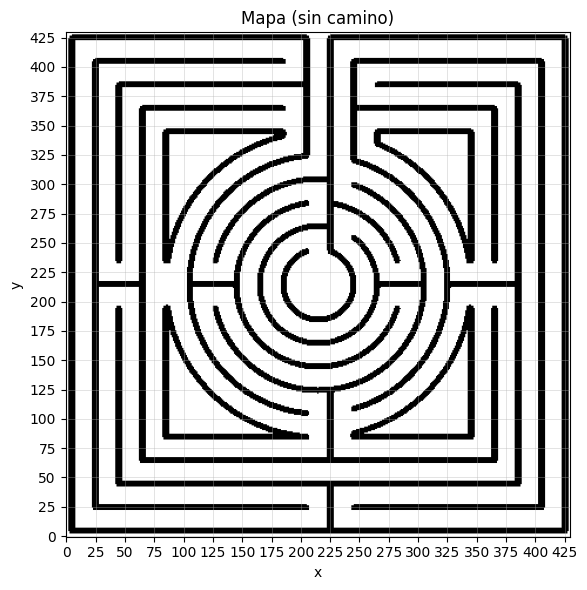

In [121]:
grid = load_occupancy_from_image(IMG_PATH, threshold=128, invert=False)
preview_map(grid)

In [122]:
# Coordenadas (x, y) en píxeles:
start = (210, 10)
goal = (225, 225)

Path length: 69


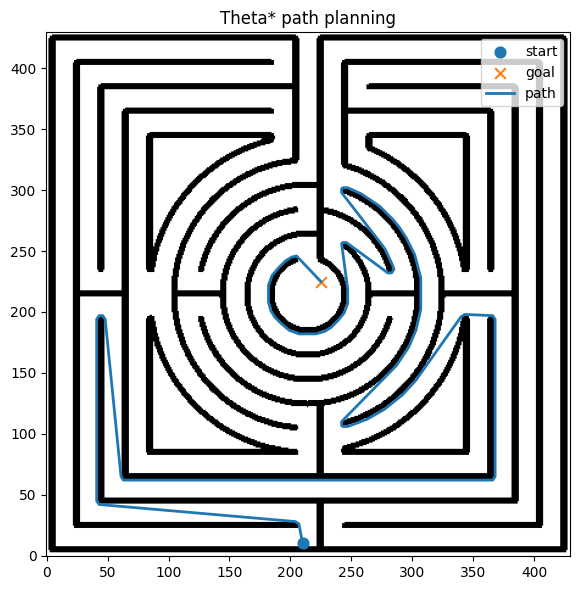

In [123]:
path = theta_star(grid, start, goal)
print("Path length:", None if path is None else len(path))

output_file = IMG_PATH + "_result.png"
plot_and_save(grid, start, goal, path, out_path=output_file)

## **Planta de El Prado**

In [124]:
IMG_PATH =  "/content/Planta_de_El_Prado.png"

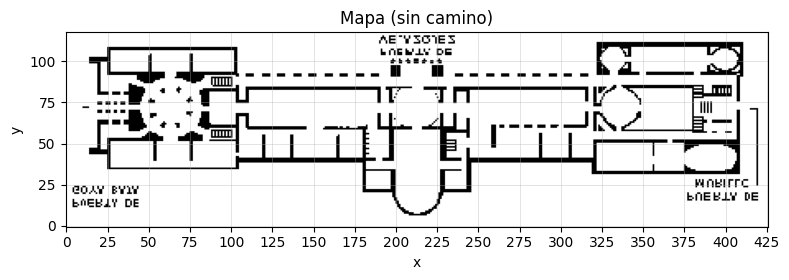

In [125]:
grid = load_occupancy_from_image(IMG_PATH, threshold=128, invert=False)

preview_map(grid)

In [126]:
# Coordenadas (x, y) en píxeles:
start = (60, 70)
goal = (400, 70)

Path length: 9


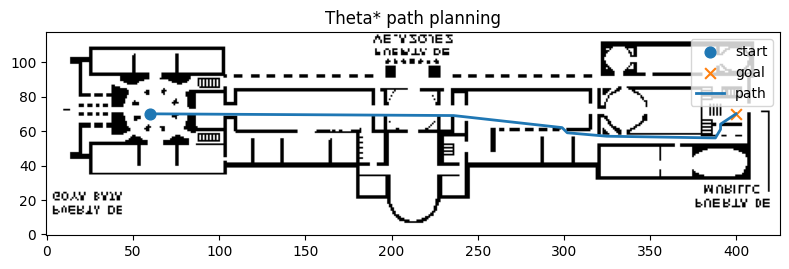

In [127]:
path = theta_star(grid, start, goal)
print("Path length:", None if path is None else len(path))

output_file = IMG_PATH + "_result.png"
plot_and_save(grid, start, goal, path, out_path=output_file)

## **Ejemplo Maze01-01**

In [128]:
IMG_PATH =  "/content/Maze01-01.png"

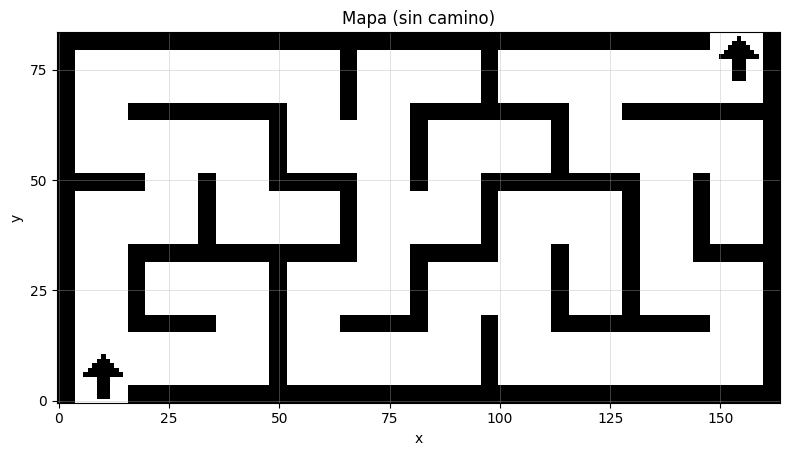

In [129]:
grid = load_occupancy_from_image(IMG_PATH, threshold=128, invert=False)

preview_map(grid)

In [130]:
# Coordenadas (x, y) en píxeles:
start = (15, 1)
goal = (150, 80)

Path length: 24


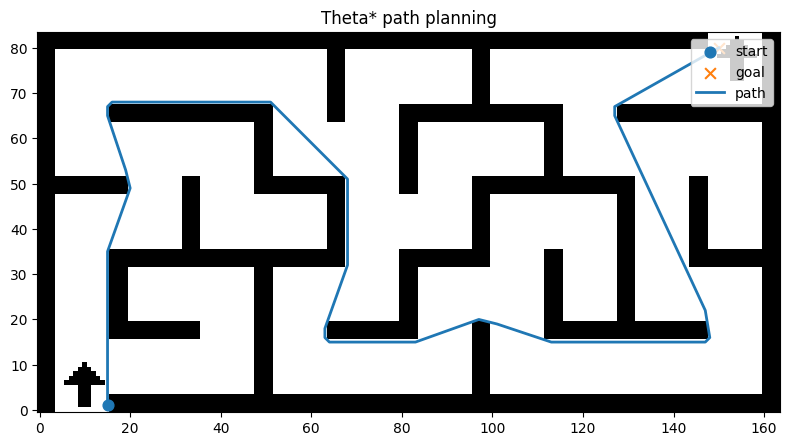

In [131]:
path = theta_star(grid, start, goal)
print("Path length:", None if path is None else len(path))

output_file = IMG_PATH + "_result.png"
plot_and_save(grid, start, goal, path, out_path=output_file)

## **Mapa Nuestro Propio**

In [132]:
IMG_PATH =  "/content/mapa_propio.png"

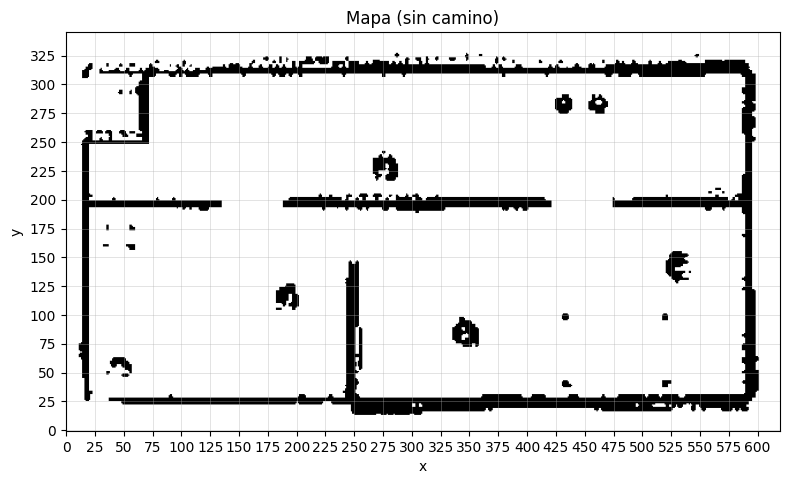

In [133]:
grid = load_occupancy_from_image(IMG_PATH, threshold=128, invert=False)

preview_map(grid)

In [134]:
# Coordenadas (x, y) en píxeles:
start = (25, 25)
goal = (575, 300)

Path length: 9


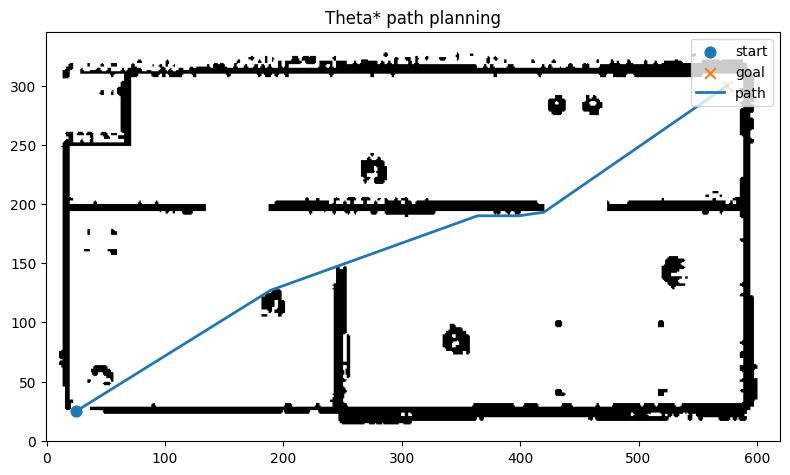

In [135]:
path = theta_star(grid, start, goal)
print("Path length:", None if path is None else len(path))

output_file = IMG_PATH + "_result.png"
plot_and_save(grid, start, goal, path, out_path=output_file)

## **Conclusión Algoritmo Theta**

# **Algoritmo RRT**

In [136]:
import random
import math
from dataclasses import dataclass
from typing import List, Tuple, Optional

def is_free(grid, x, y):
    h, w = grid.shape
    return 0 <= x < w and 0 <= y < h and grid[y, x] == 0

def bresenham_line(x0, y0, x1, y1):
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    x, y = x0, y0
    while True:
        yield x, y
        if x == x1 and y == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x += sx
        if e2 < dx:
            err += dx
            y += sy

def collision_free(grid, a: Tuple[int,int], b: Tuple[int,int]) -> bool:
    # True si el segmento a->b NO toca obstáculos
    for x, y in bresenham_line(a[0], a[1], b[0], b[1]):
        if not is_free(grid, x, y):
            return False
    return True

def dist(a: Tuple[int,int], b: Tuple[int,int]) -> float:
    return math.hypot(a[0]-b[0], a[1]-b[1])

def steer(from_pt: Tuple[int,int], to_pt: Tuple[int,int], step_size: float) -> Tuple[int,int]:
    """
    Avanza desde from_pt hacia to_pt un máximo de step_size (en píxeles).
    Devuelve un nuevo punto entero (x,y).
    """
    x0, y0 = from_pt
    x1, y1 = to_pt
    d = dist(from_pt, to_pt)
    if d == 0:
        return from_pt
    t = min(1.0, step_size / d)
    nx = int(round(x0 + (x1 - x0) * t))
    ny = int(round(y0 + (y1 - y0) * t))
    return (nx, ny)

def sample_free_point(grid, max_tries=10_000) -> Tuple[int,int]:
    h, w = grid.shape
    for _ in range(max_tries):
        x = random.randrange(0, w)
        y = random.randrange(0, h)
        if grid[y, x] == 0:
            return (x, y)
    raise RuntimeError("No he podido samplear un punto libre; ¿mapa casi todo obstáculo?")


In [137]:
@dataclass
class RRTNode:
    pt: Tuple[int,int]
    parent: Optional[int]  # índice en la lista de nodos

def nearest_node_index(nodes: List[RRTNode], q: Tuple[int,int]) -> int:
    best_i = 0
    best_d = float("inf")
    for i, n in enumerate(nodes):
        d = dist(n.pt, q)
        if d < best_d:
            best_d = d
            best_i = i
    return best_i

def reconstruct_rrt_path(nodes: List[RRTNode], goal_index: int) -> List[Tuple[int,int]]:
    path = []
    i = goal_index
    while i is not None:
        path.append(nodes[i].pt)
        i = nodes[i].parent
    path.reverse()
    return path

def rrt_plan(
    grid,
    start: Tuple[int,int],
    goal: Tuple[int,int],
    step_size: float = 15.0,
    goal_sample_rate: float = 0.05,  # 5% de las veces samplea el goal (bias)
    max_iters: int = 20_000,
    goal_tolerance: float = 15.0,
) -> Optional[List[Tuple[int,int]]]:
    """
    RRT básico sobre occupancy grid.
    - start/goal: (x,y) en píxeles
    - step_size: cuánto avanza cada expansión
    - goal_sample_rate: probabilidad de muestrear directamente el goal
    - goal_tolerance: si un nodo queda a <= tol del goal e incluye colisión-free, conectamos.
    """
    if not is_free(grid, *start):
        raise ValueError(f"Start {start} no es libre.")
    if not is_free(grid, *goal):
        raise ValueError(f"Goal {goal} no es libre.")

    nodes: List[RRTNode] = [RRTNode(start, parent=None)]

    for _ in range(max_iters):
        # 1) sample
        if random.random() < goal_sample_rate:
            q_rand = goal
        else:
            q_rand = sample_free_point(grid)

        # 2) nearest
        i_near = nearest_node_index(nodes, q_rand)
        q_near = nodes[i_near].pt

        # 3) steer
        q_new = steer(q_near, q_rand, step_size)

        # 4) validar punto nuevo
        if q_new == q_near:
            continue
        if not is_free(grid, *q_new):
            continue
        if not collision_free(grid, q_near, q_new):
            continue

        # 5) añadir
        nodes.append(RRTNode(q_new, parent=i_near))
        i_new = len(nodes) - 1

        # 6) ¿llego al goal?
        if dist(q_new, goal) <= goal_tolerance:
            if collision_free(grid, q_new, goal):
                nodes.append(RRTNode(goal, parent=i_new))
                return reconstruct_rrt_path(nodes, len(nodes) - 1)

    return None


## **Ejemplo Labirinto_003**

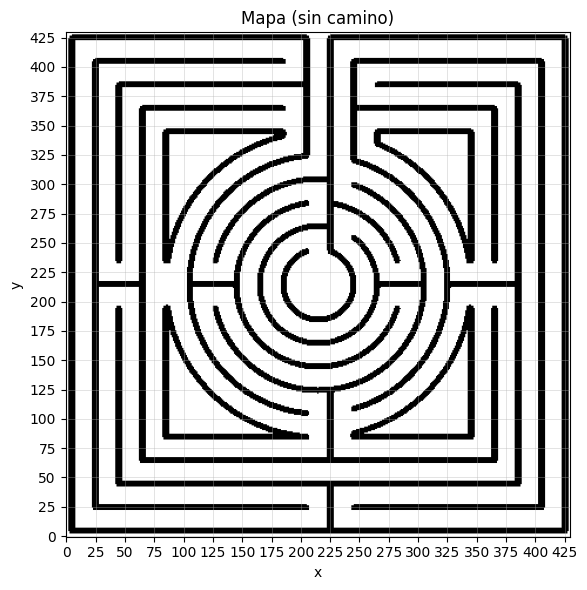

In [138]:
IMG_PATH =  "/content/Labirinto_003.png"

grid = load_occupancy_from_image(IMG_PATH, threshold=128, invert=False)
preview_map(grid)

In [140]:
start = (210, 10)
goal = (225, 225)

path_rrt = rrt_plan(
    grid,
    start,
    goal,
    step_size=2,
    goal_sample_rate=0.08,
    max_iters=60000,
    goal_tolerance=20,
)

if path_rrt == None:
  print("ERROR. No se encontró un camino válido")
else:
  plot_and_save(grid, start, goal, path_rrt, out_path="rrt_result.png", title="RRT planning")


ERROR. No se encontró un camino válido


## **Planta de El Prado**

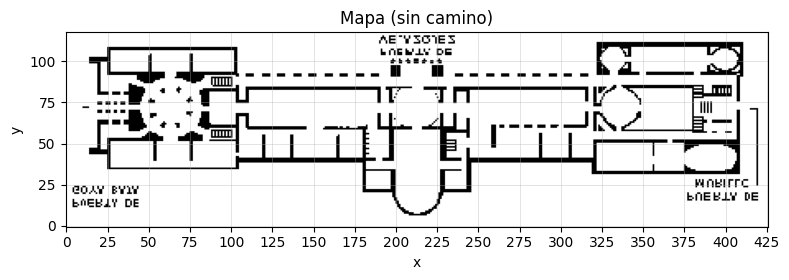

In [141]:
IMG_PATH =  "/content/Planta_de_El_Prado.png"

grid = load_occupancy_from_image(IMG_PATH, threshold=128, invert=False)
preview_map(grid)

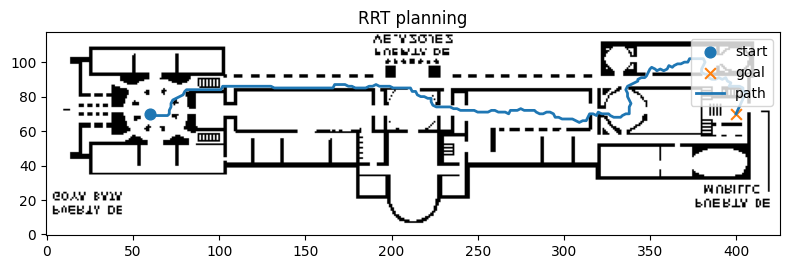

In [142]:
start = (60, 70)
goal = (400, 70)

path_rrt = rrt_plan(
    grid,
    start,
    goal,
    step_size=2,
    goal_sample_rate=0.08,
    max_iters=60000,
    goal_tolerance=20,
)

if path_rrt == None:
  print("ERROR. No se encontró un camino válido")
else:
  plot_and_save(grid, start, goal, path_rrt, out_path="rrt_result.png", title="RRT planning")

## **Ejemplo Maze01-01**

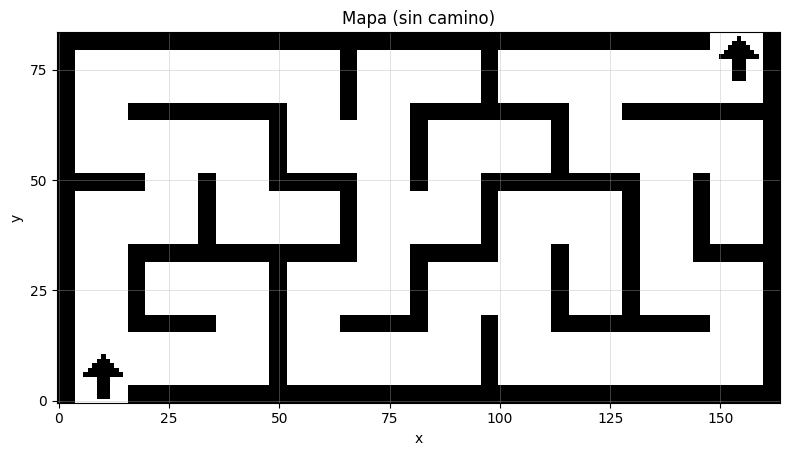

In [143]:
IMG_PATH =  "/content/Maze01-01.png"

grid = load_occupancy_from_image(IMG_PATH, threshold=128, invert=False)
preview_map(grid)

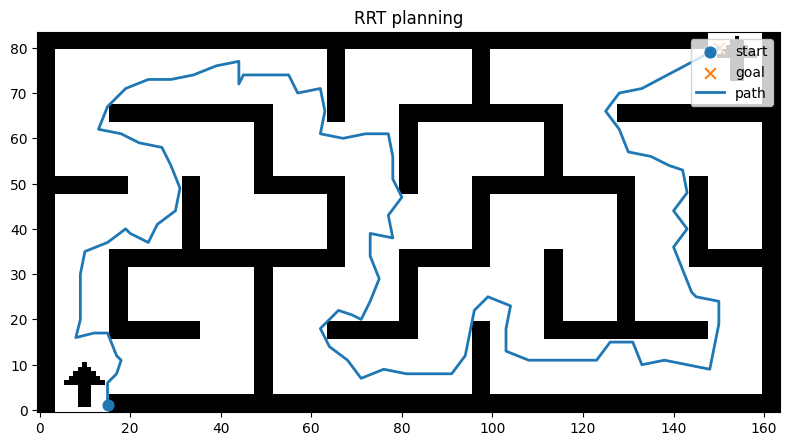

In [144]:
# Coordenadas (x, y) en píxeles:
start = (15, 1)
goal = (150, 80)

path_rrt = rrt_plan(
    grid,
    start,
    goal,
    step_size=5,
    goal_sample_rate=0.08,
    max_iters=60000,
    goal_tolerance=20,
)


if path_rrt == None:
  print("ERROR. No se encontró un camino válido")
else:
  plot_and_save(grid, start, goal, path_rrt, out_path="rrt_result.png", title="RRT planning")


## **Mapa Nuestro Propio**

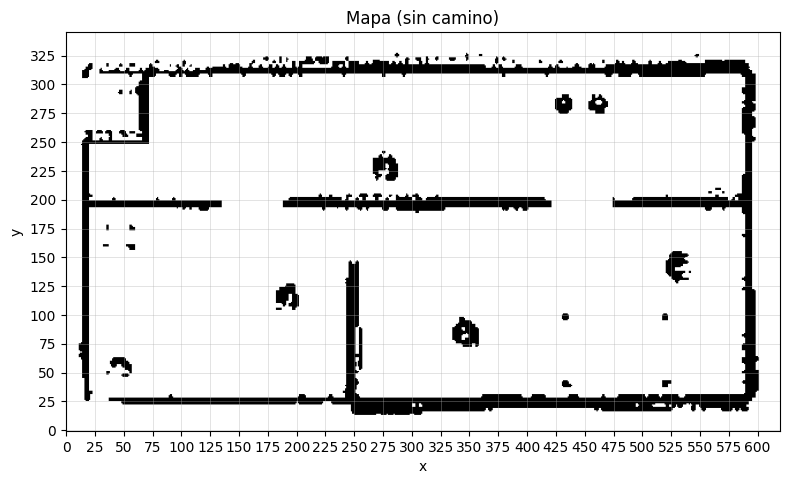

In [145]:
IMG_PATH =  "/content/mapa_propio.png"

grid = load_occupancy_from_image(IMG_PATH, threshold=128, invert=False)
preview_map(grid)

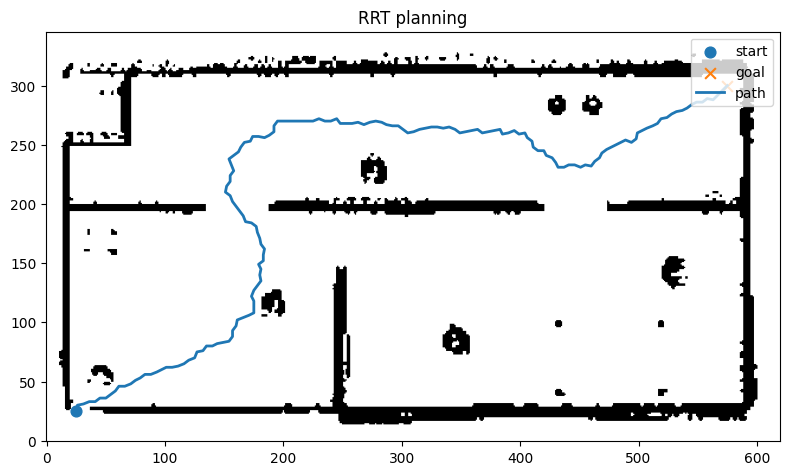

In [146]:
start = (25, 25)
goal = (575, 300)

path_rrt = rrt_plan(
    grid,
    start,
    goal,
    step_size=5,
    goal_sample_rate=0.08,
    max_iters=60000,
    goal_tolerance=20,
)


if path_rrt == None:
  print("ERROR. No se encontró un camino válido")
else:
  plot_and_save(grid, start, goal, path_rrt, out_path="rrt_result.png", title="RRT planning")


# **Comparación entre Algoritmos**

A continuación, comparamos los mapas creados por cada algoritmo, por ejemplo, para  ``` Maze01-01 ```.

